<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S12/imagenet_S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

! git clone https://github.com/namanphy/EVA5.git
! pip install git+https://github.com/albumentations-team/albumentations.git

sys.path.append('EVA5/S12/')

In [11]:
import cuda
from data import TinyImageNet, data_loader
from model import ResNet18
from model.optimizer import sgd_optimizer
from model.loss import cross_entropy_loss
from engine import Trainer
from utils import set_seed, plot_metric, identify_misclassification, plot_results
# from engine.lr_finder import LRFinder
from engine.lr_scheduler import reduce_lr_on_plateau
import matplotlib.pyplot as plt

In [3]:
set_seed(123)
use_cuda = cuda.cuda_is_available()
device = cuda.enable_cuda()

In [4]:
train_set = TinyImageNet('./data', train=True, apply_transform=True, horizontal_flip=0.2, vertical_flip=0.1, cutout=0.3, cutout_hw_ratio=4)
test_set = TinyImageNet('./data', train=False, apply_transform=True)

Done.
starting loading data
finished loading data, in 36.1992290019989 seconds
Transforms :  {'train': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'padding': (0, 0), 'crop': (0, 0), 'rotation': 0, 'horizontal_flip': 0.2, 'vertical_flip': 0.1, 'cutout': 0.3, 'cutout_height': 16, 'cutout_width': 16}
Files already present.
starting loading data


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


finished loading data, in 35.32726788520813 seconds
Transforms :  {'train': False, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'padding': (0, 0), 'crop': (0, 0), 'rotation': 0, 'horizontal_flip': 0.0, 'vertical_flip': 0.0, 'cutout': 0.0, 'cutout_height': 32, 'cutout_width': 32}


In [5]:
# Loading the datasets into Pytorch Dataloaders
train_loader = data_loader(train_set, 128, use_cuda, num_workers=4)
test_loader = data_loader(test_set, 128, use_cuda, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Data Visualisation : Seeing some images

In [6]:
classes = train_set.classes
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('shape of one image - ', images[0].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


shape of one image -  torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


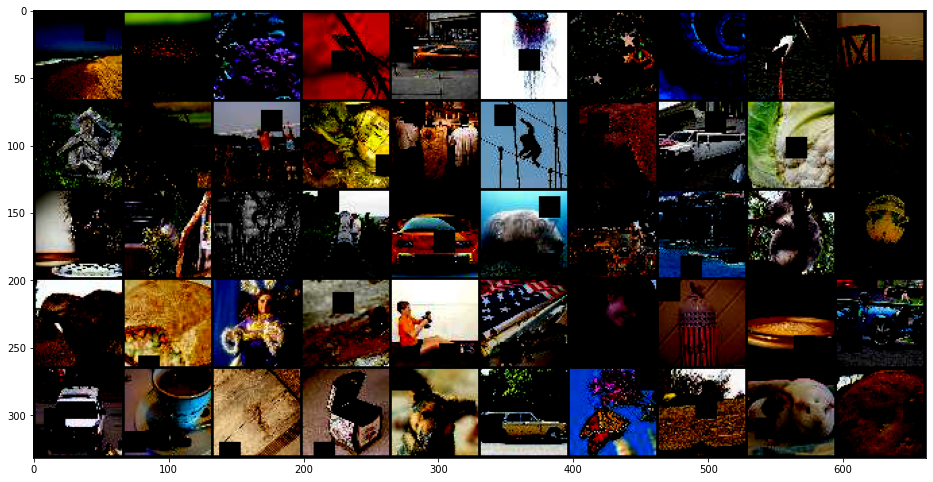

In [7]:
# Unnormalise here
import torchvision
import numpy as np
grid = torchvision.utils.make_grid(images[:50], nrow=10)
plt.figure(figsize=(16,16))
plt.imshow(np.transpose(grid, (1,2,0)))

## Model - set up

In [15]:
model = ResNet18(num_classes=len(classes))
model.name = 'ResNet18' # Giving my model a name
model.summary(input_size=(3, 64, 64), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Setting up training

In [16]:
results = {}  # empty dict to store results

criterion = cross_entropy_loss()
optimizer = sgd_optimizer(model, lr=0.01, l2_factor=0)

In [17]:
# Setting up the trainer
scheduler = reduce_lr_on_plateau(optimizer, factor=0.2, patience=2, min_lr=0.000001)
trainer = Trainer(model, optimizer, criterion, train_loader, valid_data_loader=test_loader, 
                  callbacks=[scheduler], l1_loss=False)
results['resnet18'] = trainer.train(40)
trainer.save('cifar10_model')

  0%|          | 0/602 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=3.5418198108673096 Batch_id=601 Accuracy=8.41: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.9748, Accuracy: 4218/33000 (13%)

------------ EPOCH 2 -------------


Loss=3.2418088912963867 Batch_id=601 Accuracy=18.93: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.8424, Accuracy: 5503/33000 (17%)

------------ EPOCH 3 -------------


Loss=2.9711780548095703 Batch_id=601 Accuracy=25.41: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.2505, Accuracy: 8286/33000 (25%)

------------ EPOCH 4 -------------


Loss=2.8822381496429443 Batch_id=601 Accuracy=30.76: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.2409, Accuracy: 8551/33000 (26%)

------------ EPOCH 5 -------------


Loss=2.7311415672302246 Batch_id=601 Accuracy=34.79: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8341, Accuracy: 10977/33000 (33%)

------------ EPOCH 6 -------------


Loss=2.5884389877319336 Batch_id=601 Accuracy=38.41: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8500, Accuracy: 11071/33000 (34%)

------------ EPOCH 7 -------------


Loss=2.395667791366577 Batch_id=601 Accuracy=41.80: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7399, Accuracy: 11824/33000 (36%)

------------ EPOCH 8 -------------


Loss=2.041016101837158 Batch_id=601 Accuracy=44.41: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7649, Accuracy: 11902/33000 (36%)

------------ EPOCH 9 -------------


Loss=2.200453758239746 Batch_id=601 Accuracy=47.34: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4755, Accuracy: 13776/33000 (42%)

------------ EPOCH 10 -------------


Loss=1.6014792919158936 Batch_id=601 Accuracy=49.70: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7746, Accuracy: 12253/33000 (37%)

------------ EPOCH 11 -------------


Loss=1.8375132083892822 Batch_id=601 Accuracy=52.11: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5150, Accuracy: 13715/33000 (42%)

------------ EPOCH 12 -------------


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4889, Accuracy: 13905/33000 (42%)

------------ EPOCH 13 -------------


Loss=1.4759513139724731 Batch_id=601 Accuracy=64.74: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9493, Accuracy: 17277/33000 (52%)

------------ EPOCH 14 -------------


Loss=1.0894370079040527 Batch_id=601 Accuracy=67.31: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9464, Accuracy: 17316/33000 (52%)

------------ EPOCH 15 -------------


Loss=1.2594019174575806 Batch_id=601 Accuracy=68.77: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9350, Accuracy: 17359/33000 (53%)

------------ EPOCH 16 -------------


Loss=1.527499794960022 Batch_id=601 Accuracy=70.10: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9772, Accuracy: 17217/33000 (52%)

------------ EPOCH 17 -------------


Loss=1.2786251306533813 Batch_id=601 Accuracy=71.24: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9936, Accuracy: 17068/33000 (52%)

------------ EPOCH 18 -------------


Loss=1.358506441116333 Batch_id=601 Accuracy=72.56: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.0043, Accuracy: 17036/33000 (52%)

------------ EPOCH 19 -------------


Loss=0.8444359302520752 Batch_id=601 Accuracy=76.39: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9026, Accuracy: 17737/33000 (54%)

------------ EPOCH 20 -------------


Loss=1.0383254289627075 Batch_id=601 Accuracy=77.10: 100%|██████████| 602/602 [02:25<00:00,  4.15it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9045, Accuracy: 17782/33000 (54%)

------------ EPOCH 21 -------------


Loss=0.7956735491752625 Batch_id=601 Accuracy=77.78: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9057, Accuracy: 17719/33000 (54%)

------------ EPOCH 22 -------------


Loss=0.753206729888916 Batch_id=601 Accuracy=78.09: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9132, Accuracy: 17685/33000 (54%)

------------ EPOCH 23 -------------


Loss=0.954691469669342 Batch_id=601 Accuracy=79.03: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9017, Accuracy: 17763/33000 (54%)

------------ EPOCH 24 -------------


Loss=0.9172201156616211 Batch_id=601 Accuracy=79.14: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9018, Accuracy: 17748/33000 (54%)

------------ EPOCH 25 -------------


Loss=0.8526593446731567 Batch_id=601 Accuracy=79.36: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9008, Accuracy: 17776/33000 (54%)

------------ EPOCH 26 -------------


Loss=1.0491483211517334 Batch_id=601 Accuracy=79.29: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9024, Accuracy: 17801/33000 (54%)

------------ EPOCH 27 -------------


Loss=0.9920399188995361 Batch_id=601 Accuracy=79.32: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9011, Accuracy: 17780/33000 (54%)

------------ EPOCH 28 -------------


Loss=0.7923073172569275 Batch_id=601 Accuracy=79.60: 100%|██████████| 602/602 [02:25<00:00,  4.14it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9042, Accuracy: 17792/33000 (54%)

------------ EPOCH 29 -------------


Loss=1.0281704664230347 Batch_id=601 Accuracy=79.76: 100%|██████████| 602/602 [02:26<00:00,  4.12it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9018, Accuracy: 17809/33000 (54%)

------------ EPOCH 30 -------------


Loss=0.7209702730178833 Batch_id=601 Accuracy=79.79: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9040, Accuracy: 17793/33000 (54%)

------------ EPOCH 31 -------------


Loss=0.7803099155426025 Batch_id=601 Accuracy=79.91: 100%|██████████| 602/602 [02:26<00:00,  4.12it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9043, Accuracy: 17788/33000 (54%)

------------ EPOCH 32 -------------


Loss=1.111523985862732 Batch_id=601 Accuracy=79.91: 100%|██████████| 602/602 [02:26<00:00,  4.12it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9036, Accuracy: 17806/33000 (54%)

------------ EPOCH 33 -------------


Loss=0.8531195521354675 Batch_id=601 Accuracy=79.64: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9027, Accuracy: 17797/33000 (54%)

------------ EPOCH 34 -------------


Loss=0.7920873761177063 Batch_id=601 Accuracy=79.90: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9039, Accuracy: 17770/33000 (54%)

------------ EPOCH 35 -------------


Loss=0.7398872375488281 Batch_id=601 Accuracy=79.87: 100%|██████████| 602/602 [02:26<00:00,  4.12it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9018, Accuracy: 17788/33000 (54%)

------------ EPOCH 36 -------------


Loss=0.7111656665802002 Batch_id=601 Accuracy=79.66: 100%|██████████| 602/602 [02:26<00:00,  4.12it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9011, Accuracy: 17811/33000 (54%)

------------ EPOCH 37 -------------


Loss=1.0672926902770996 Batch_id=601 Accuracy=79.85: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9049, Accuracy: 17787/33000 (54%)

------------ EPOCH 38 -------------


Loss=0.7230756282806396 Batch_id=601 Accuracy=80.07: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9039, Accuracy: 17808/33000 (54%)

------------ EPOCH 39 -------------


Loss=0.7551589012145996 Batch_id=601 Accuracy=79.77: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9022, Accuracy: 17770/33000 (54%)

------------ EPOCH 40 -------------


Loss=1.0841867923736572 Batch_id=601 Accuracy=79.86: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]



Test set: Average loss: 1.9033, Accuracy: 17821/33000 (54%)



## Analyzing Results

In [18]:
from statistics import mean
print('Train accuracy - ',  max(results['resnet18']['train_acc']))
print('Test accuracy - ',  max(results['resnet18']['test_acc']))

Train accuracy -  80.06753246753247
Test accuracy -  54.0030303030303


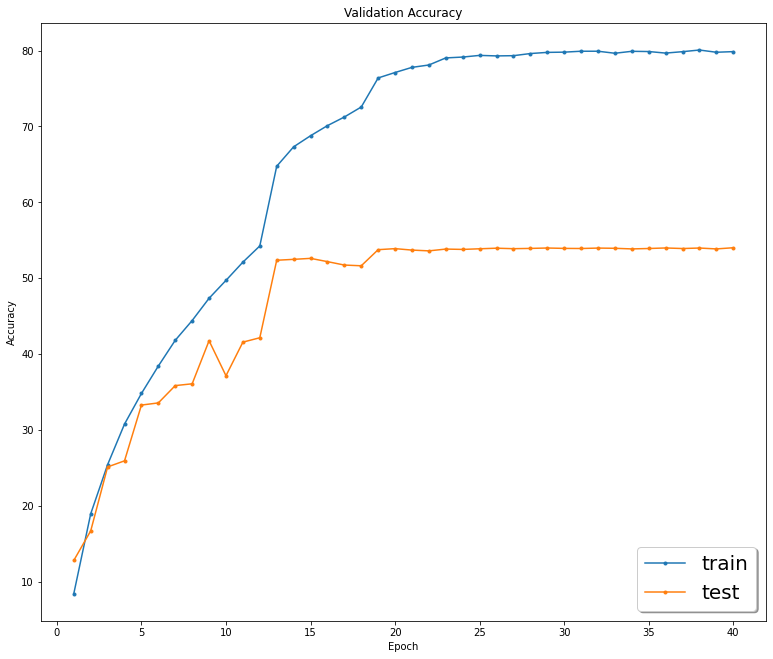

In [19]:
plot_metric({'train': results['resnet18']['train_acc'], 'test': results['resnet18']['test_acc']}, 'Accuracy')